# New Feature, SVM, Stacking -- Kaggle| House Price Prediction

Following from Tutorial 1, we are going to use Tree to predict the house price.

Competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

Stacked Regression: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

Download data from: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

#### Description:

With 79 explanatory variables describing (almost) every aspect of residential homes, this competition challenges you to predict the final price of each home.

## A very important note:

When you participate in this kaggle contest, you may find that some people achieve a score about zero (0.00000~0.00044), and they are ranked in the top ~70th. Don't get upset if your score is far from theirs, because they are just cheeting (I am 99% sure). They found the original labels of the testing set. There is no meaning for us to do so and we will follow the course and learn from the contest.

In [109]:
import numpy as np
import pandas as pd
from scipy.stats import norm, skew
from scipy import stats
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Contents:

* step 0. import data
* step 1. Data Preprocessing (this part is the same as the one in Tutorial 2)
    * step 1.1 remove outliers
    * step 1.2 log-transform of target variable
    * step 1.3 handling missing data for both training data and testing data
    * step 1.4 Transforming some numerical variables that are really categorical
    * step 1.5 Adding one more important feature
    * step 1.6 Box Cox transformation of (highly) skewed numerical features
    * step 1.7 Label Encoding some categorical variables that may contain information in their ordering set
    * step 1.8 getting the new train and test set
* step 2. Modeling
    * step 2.1 Define a cross validation strategy
    * step 2.2 DecisionTreeRegressor
    * step 2.3 RandomForestRegressor
    * step 2.4 GradientBoostingRegressor
    * step 2.5 XGBoost
    * step 2.6 lightGBM
    * step 2.7 CatBoosting
    * step 2.8 SVM
        * step 2.8.1 𝜖-SVR
        * step 2.8.2 𝜈-SVR
    * Step 2.9 Ridge
    * step 2.10 Stacked Regressor
    * step 2.11 Model Aggregation

## step 0. import data

In [110]:
df_train = pd.read_csv('./data/house-price/train.csv')
df_test = pd.read_csv('./data/house-price/test.csv')
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


In [111]:
##display the first five rows of the train dataset.
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [112]:
##display the first five rows of the test dataset.
df_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [113]:
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

## Step 1. Data Preprocessing

### step 1.1  remove outliers

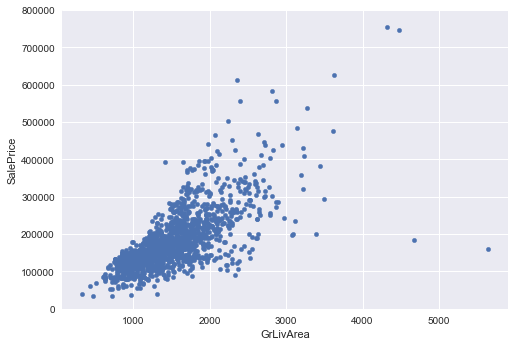

In [114]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'  # Above ground living area square feet
df_train.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [115]:
#deleting points with top 2 largest 'GrLivArea'
outliers = df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
print(outliers['GrLivArea'])
df_train = df_train.drop(outliers['GrLivArea'].index)

1298    5642
523     4676
Name: GrLivArea, dtype: int64


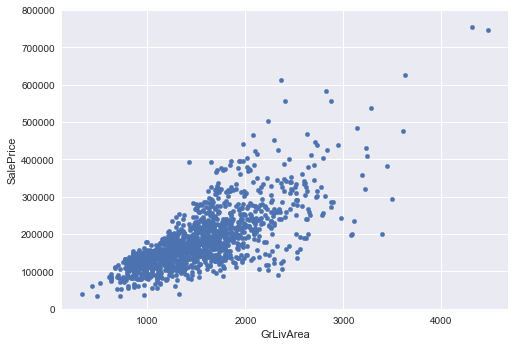

In [116]:
#check the plot grlivarea/saleprice again
var = 'GrLivArea'  # Above ground living area square feet
df_train.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### step 1.2 log-transform of target variable

/Users/zhicongliang/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

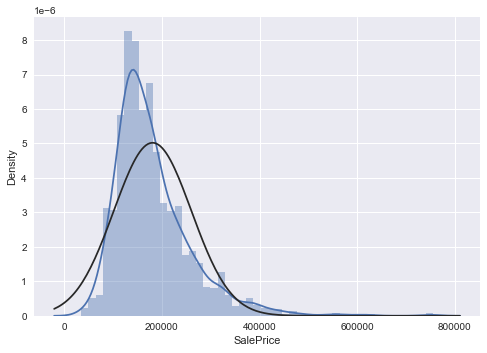

In [117]:
# histogram and normal probability plot
# fit=norm here further plots the curve of normal distribution with the same mean and variance as df_train['SalePrice']
sns.distplot(df_train['SalePrice'], fit=norm)

/Users/zhicongliang/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

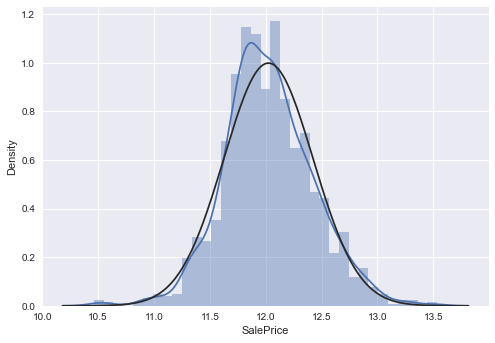

In [118]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
sns.distplot(df_train['SalePrice'], fit=norm)

### step 1.3 handling missing data for both training data and testing data

In [119]:
# we firstly concatenate the train and test data in the same dataframe
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [120]:
# count NaN in each columns and sort them in descending order
total = all_data.isnull().sum().sort_values(ascending=False)
percent = total/all_data.shape[0]
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


In [121]:
# imputing missing values
# no pool
all_data["PoolQC"] = all_data["PoolQC"].fillna("None") 
# data description says NA means "no misc feature"
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
# data description says NA means "no alley access"
all_data["Alley"] = all_data["Alley"].fillna("None")
# data description says NA means "no fence"
all_data["Fence"] = all_data["Fence"].fillna("None")
# data description says NA means "no fireplace"
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
# LotFrontage : Since the area of each street connected to the house property most likely 
# have a similar area to other houses in its neighborhood, 
# we can fill in missing values by the median LotFrontage of the neighborhood.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
# missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
# For all these categorical basement-related features, NaN means that there is no basement.  
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. 
# We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
# MSZoning (The general zoning classification) : 'RL' is by far the most common value. 
# So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
# Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)
# Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")
# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
# SaleType : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
# MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [122]:
# check if we still have missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = total/all_data.shape[0]
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
SaleCondition,0,0.0
BsmtQual,0,0.0
Exterior1st,0,0.0


### step 1.4 Transforming some numerical variables that are really categorical

In [123]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
#all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### step 1.5 Adding one more important feature

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [124]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [125]:
all_data.dtypes

MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold            object
YrSold            object
SaleType          object
SaleCondition     object
TotalSF          float64
Length: 79, dtype: object

### step 1.6 Box Cox transformation of (highly) skewed numerical features

In [126]:
# get all numerical feature
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

from scipy.stats import norm, skew
# Check the skewness of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(-1)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [127]:
# We use the scipy function boxcox1p which computes the Box-Cox transformation of 1+x .
# Note that setting  λ=0  is equivalent to log1p used above for the target variable.
# See http://onlinestatbook.com/2/transformations/box-cox.html for more details on Box Cox Transformation 
# as well as the scipy function's page: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    

There are 34 skewed numerical features to Box Cox transform


In [128]:
# check skewness after box-cox transformation
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skewness of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(-1)


Skew in numerical features: 



,Skew
PoolArea,15.759529
3SsnPorch,8.921650
LowQualFinSF,8.741030
MiscVal,5.594963
BsmtHalfBath,3.786685
KitchenAbvGr,3.697303
ScreenPorch,2.977052
BsmtFinSF2,2.563235
EnclosedPorch,2.024321
MasVnrArea,0.637388


### step 1.8 Craeting New Features

In [129]:
all_data['BsmtFinType1_Unf_bool'] = 1*(all_data['BsmtFinType1'] == 'Unf')
all_data['HasWoodDeck'] = (all_data['WoodDeckSF'] == 0) * 1
all_data['HasOpenPorch'] = (all_data['OpenPorchSF'] == 0) * 1
all_data['HasEnclosedPorch'] = (all_data['EnclosedPorch'] == 0) * 1
all_data['Has3SsnPorch'] = (all_data['3SsnPorch'] == 0) * 1
all_data['HasScreenPorch'] = (all_data['ScreenPorch'] == 0) * 1
all_data['YearsSinceRemodel'] = all_data['YrSold'].astype(int) - all_data['YearRemodAdd'].astype(int)
all_data['Total_Home_Quality'] = all_data['OverallQual'] + all_data['OverallCond']
all_data = all_data.drop(['Street', 'PoolQC',], axis=1)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_data['GarageArea'] = all_data['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_data['GarageCars'] = all_data['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_data['LotFrontage'] = all_data['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_data['MasVnrArea'] = all_data['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### step 1.9 Feature Transformation

Let's create more features by calculating the log and square transformations of our numerical features. We do this manually, because ML models won't be able to reliably tell if log(feature) or feature^2 is a predictor of the SalePrice.

In [130]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log1p(res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

In [131]:
log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_data = logs(all_data, log_features)

In [132]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

In [133]:
squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
all_data = squares(all_data, squared_features)

### step 2.0 Label Encoding some categorical variables that may contain information in their ordering set

In [134]:
#convert categorical variable into dummy
all_data = pd.get_dummies(all_data)

In [135]:
all_data.columns[all_data.columns.str.contains('MSSubClass')]

Index(['MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180',
       'MSSubClass_190', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40',
       'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70',
       'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90'],
      dtype='object')

In [136]:
all_data

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.831328,19.212182,2.440268,2.055642,14.187527,14.187527,8.059126,11.170327,0.0,7.483296,...,0,0,0,1,0,0,0,0,1,0
1,6.221214,19.712205,2.259674,2.602594,14.145138,14.145138,54.598150,12.062832,0.0,8.897844,...,0,0,0,1,0,0,0,0,1,0
2,5.914940,20.347241,2.440268,2.055642,14.184404,14.185966,7.646538,10.200343,0.0,9.917060,...,0,0,0,1,0,0,0,0,1,0
3,5.684507,19.691553,2.440268,2.055642,14.047529,14.135652,54.598150,8.274266,0.0,10.468500,...,0,0,0,1,1,0,0,0,0,0
4,6.314735,21.325160,2.602594,2.055642,14.182841,14.182841,9.391827,10.971129,0.0,10.221051,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,3.932510,14.081426,1.820334,2.440268,14.135652,14.135652,54.598150,665.141633,0.0,10.496872,...,0,0,0,1,0,0,0,0,1,0
2913,3.932510,14.013314,1.820334,2.055642,14.135652,14.135652,54.598150,8.622254,0.0,8.978567,...,0,0,0,1,1,0,0,0,0,0
2914,7.620056,22.782058,2.055642,2.440268,14.119786,14.176584,54.598150,12.703313,0.0,0.000000,...,0,0,0,1,1,0,0,0,0,0
2915,5.744420,20.046557,2.055642,2.055642,14.170316,14.170316,54.598150,9.301176,0.0,10.630386,...,0,0,0,1,0,0,0,0,1,0


### step 1.8 getting the new train and test set

In [137]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## step 2. Modeling

In [31]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler

from IPython.display import Image
from six import StringIO
import graphviz

### step 2.1 Define a cross validation strategy

We divide our data into K folds, then we train our model for K times. In each time, we will exclude one fold of data as validation data and use the others as training data. In this case, we can objectively evaluate our model and eliminate the overfitting problem in paramter-tuning.

In [32]:
#Validation function

# ensure that you are using the same/similar evaluation metric as the contest will use

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

def get_cv_rmse(model, train, y_train):
    n_folds = 5
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = folds))
    return rmse

def get_rmse(y, y_pred):
    return np.sqrt(np.mean((y-y_pred)**2))

## step 2.3 RandomForestRegressor

In [179]:
from sklearn.ensemble import RandomForestRegressor

In [183]:
# feature normalization usually would not affect the result of decision tree
random_forest = RandomForestRegressor(n_estimators=1200,
                                      max_depth=15,
                                      min_samples_split=5,
                                      min_samples_leaf=5,
                                      max_features=None,
                                      oob_score=True,
                                      random_state=42)

In [184]:
# the score of the given model in cross-validation
score = get_cv_rmse(random_forest, train, y_train)
print(score)
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[0.13036181 0.15050873 0.14204317 0.12361174 0.14807434]

Random Forest score: 0.1389 (0.0103)



In [185]:
# define the parameters you would like to search
ccp_alphas = np.linspace(0, 1e-3, 10)
tuned_parameters = [{
                     'ccp_alpha': ccp_alphas,
                     }]

In [186]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', verbose=2)
regressor.fit(train.values, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................................ccp_alpha=0.0; total time=  21.9s
[CV] END ......................................ccp_alpha=0.0; total time=  22.4s
[CV] END ......................................ccp_alpha=0.0; total time=  22.2s
[CV] END ......................................ccp_alpha=0.0; total time=  22.5s
[CV] END ......................................ccp_alpha=0.0; total time=  22.3s
[CV] END ...................ccp_alpha=0.00011111111111111112; total time=  23.0s
[CV] END ...................ccp_alpha=0.00011111111111111112; total time=  23.3s
[CV] END ...................ccp_alpha=0.00011111111111111112; total time=  22.9s
[CV] END ...................ccp_alpha=0.00011111111111111112; total time=  21.7s
[CV] END ...................ccp_alpha=0.00011111111111111112; total time=  21.5s
[CV] END ...................ccp_alpha=0.00022222222222222223; total time=  21.8s
[CV] END ...................ccp_alpha=0.00022222

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=15, max_features=None,
                                             min_samples_leaf=5,
                                             min_samples_split=5,
                                             n_estimators=1200, oob_score=True,
                                             random_state=42),
             param_grid=[{'ccp_alpha': array([0.        , 0.00011111, 0.00022222, 0.00033333, 0.00044444,
       0.00055556, 0.00066667, 0.00077778, 0.00088889, 0.001     ])}],
             scoring='neg_mean_squared_error', verbose=2)

In [189]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,22.160992,0.217915,0.098517,0.002725,0,{'ccp_alpha': 0.0},-0.017955,-0.019583,-0.021743,-0.016912,-0.019923,-0.019223,0.001668,1
1,22.380240,0.729739,0.094180,0.003808,0.000111111,{'ccp_alpha': 0.00011111111111111112},-0.018721,-0.020160,-0.023041,-0.017545,-0.020685,-0.020030,0.001866,2
2,22.438980,0.491379,0.093226,0.002658,0.000222222,{'ccp_alpha': 0.00022222222222222223},-0.019847,-0.021012,-0.024716,-0.018584,-0.022057,-0.021243,0.002088,3
3,23.260960,0.781628,0.099546,0.012776,0.000333333,{'ccp_alpha': 0.0003333333333333334},-0.020907,-0.021807,-0.026173,-0.019590,-0.023248,-0.022345,0.002255,4
4,22.921693,0.544305,0.091988,0.002353,0.000444444,{'ccp_alpha': 0.00044444444444444447},-0.021856,-0.022561,-0.027347,-0.020558,-0.024362,-0.023337,0.002352,5
5,22.972240,0.488937,0.093916,0.001197,0.000555556,{'ccp_alpha': 0.0005555555555555556},-0.022743,-0.023300,-0.028349,-0.021403,-0.025350,-0.024229,0.002420,6
6,23.481936,0.962622,0.087084,0.002217,0.000666667,{'ccp_alpha': 0.0006666666666666668},-0.023652,-0.024016,-0.029277,-0.022184,-0.026313,-0.025088,0.002478,7
7,23.105621,0.621898,0.107551,0.030894,0.000777778,{'ccp_alpha': 0.0007777777777777778},-0.024486,-0.024713,-0.030071,-0.022967,-0.027180,-0.025884,0.002492,8
8,23.350596,0.623931,0.096508,0.010719,0.000888889,{'ccp_alpha': 0.0008888888888888889},-0.025326,-0.025376,-0.030855,-0.023704,-0.028026,-0.026657,0.002515,9
9,22.070539,0.781068,0.087000,0.002771,0.001,{'ccp_alpha': 0.001},-0.026173,-0.026072,-0.031679,-0.024442,-0.028818,-0.027437,0.002543,10


In [190]:
# get the best model
best_random_forest = regressor.best_estimator_

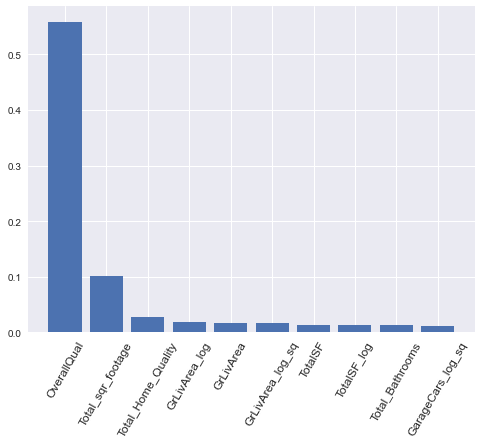

In [191]:
# find the the most important features of the tree
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
index = np.argsort(best_random_forest.feature_importances_)[::-1][:10]
features = train.columns[index]

fig = plt.figure(figsize=(8,6))
plt.bar(range(10), best_random_forest.feature_importances_[index])
plt.xticks(range(10), features, rotation=60, fontsize=12)
plt.show()

In [192]:
# REALL that we do a log transform for y_train
# make prediction
pred_train_rf = np.exp(best_random_forest.predict(train.values)) - 1
pred_test_rf = np.exp(best_random_forest.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_rf))))

Train RMSE: 0.0856


In [193]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_rf
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 2512/4657 in the leaderboard, with score=0.14965

## step 2.4 GradientBoostingRegressor

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
# here we use 'huber' loss, a loss that is more robust against outliers (https://en.wikipedia.org/wiki/Huber_loss)

# these parameter are given in the notebook "Stacked Regression"
# They also set learning_rate=0.05. However, I would still like to search for the best learning rate here,
# as a demo for parameter tuning. I think this is also how the original notebook get these parameters.

gradient_boosting = GradientBoostingRegressor(n_estimators=6000,
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10, 
                                              loss='huber', random_state =5)

In [51]:
# define the parameters you would like to search
learning_rate = [1e-3, 1e-2, 1e-1]
tuned_parameters = [{'learning_rate': learning_rate
                    }]

In [52]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(gradient_boosting, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', verbose=2)
regressor.fit(train.values, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................learning_rate=0.001; total time=  27.1s
[CV] END ................................learning_rate=0.001; total time=  27.2s
[CV] END ................................learning_rate=0.001; total time=  27.5s
[CV] END ................................learning_rate=0.001; total time=  27.3s
[CV] END ................................learning_rate=0.001; total time=  28.0s
[CV] END .................................learning_rate=0.01; total time=  24.7s
[CV] END .................................learning_rate=0.01; total time=  23.0s
[CV] END .................................learning_rate=0.01; total time=  23.7s
[CV] END .................................learning_rate=0.01; total time=  24.2s
[CV] END .................................learning_rate=0.01; total time=  22.6s
[CV] END ..................................learning_rate=0.1; total time=  23.6s
[CV] END ..................................learni

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='huber', max_depth=4,
                                                 max_features='sqrt',
                                                 min_samples_leaf=15,
                                                 min_samples_split=10,
                                                 n_estimators=6000,
                                                 random_state=5),
             param_grid=[{'learning_rate': [0.001, 0.01, 0.1]}],
             scoring='neg_mean_squared_error', verbose=2)

In [53]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,23.587495,0.751351,0.032669,0.000926,0.01,{'learning_rate': 0.01},-0.010815,-0.014571,-0.014429,-0.011471,-0.012740,-0.012805,0.001517,1
2,23.152151,0.427873,0.035425,0.002682,0.1,{'learning_rate': 0.1},-0.012563,-0.016009,-0.016177,-0.013404,-0.013068,-0.014244,0.001534,2
0,27.397788,0.323807,0.042492,0.000385,0.001,{'learning_rate': 0.001},-0.012521,-0.016990,-0.016764,-0.013700,-0.014486,-0.014892,0.001739,3


In [54]:
# get the best model
best_gb = regressor.best_estimator_

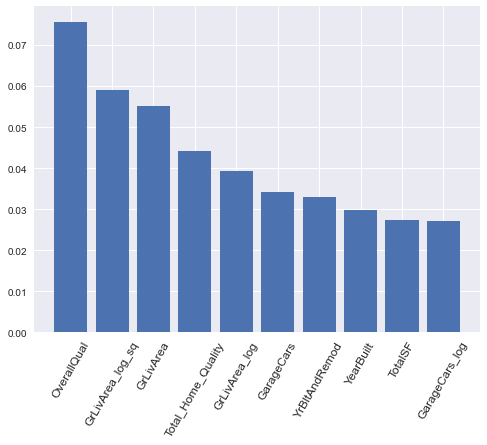

In [55]:
# find the the most important features of the tree
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
index = np.argsort(best_gb.feature_importances_)[::-1][:10]
features = train.columns[index]

fig = plt.figure(figsize=(8,6))
plt.bar(range(10), best_gb.feature_importances_[index])
plt.xticks(range(10), features, rotation=60, fontsize=12)
plt.show()

In [56]:
# REALL that we do a log transform for y_train
# make prediction
pred_train_gb = np.exp(best_gb.predict(train.values)) - 1
pred_test_gb = np.exp(best_gb.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_gb))))

Train RMSE: 0.0611


In [57]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_gb
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 742/4657 in the leaderboard, with score=0.12513

## step 2.5 XGBoost

XGBoost stands for Extreme Gradient Boosting; it is a specific implementation of the Gradient Boosting method which uses more accurate approximations to find the best tree model. It employs a number of nifty tricks that make it exceptionally successful, particularly with structured data. The most important are

1.) computing second-order gradients, i.e. second partial derivatives of the loss function (similar to Newton’s method), which provides more information about the direction of gradients and how to get to the minimum of our loss function. While regular gradient boosting uses the loss function of our base model (e.g. decision tree) as a proxy for minimizing the error of the overall model, XGBoost uses the 2nd order derivative as an approximation.

2.) And advanced regularization (L1 & L2), which improves model generalization.

XGBoost has additional advantages: training is very fast and can be parallelized / distributed across clusters.

From https://shirinsplayground.netlify.app/2018/11/ml_basics_gbm/

In [58]:
import xgboost as xgb

In [69]:
# these parameter are given in the notebook "Stacked Regression"
# They also set learning_rate=0.05. However, I would still like to search for the best learning rate here,
# as a demo for parameter tuning. I think this is also how the original notebook get these parameters.
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, nthread = -1)

In [70]:
# define the parameters you would like to search
learning_rate = [4e-5, 5e-4, 1e-3, 5e-2, 1e-1]
tuned_parameters = [{'learning_rate': learning_rate
                    }]

In [71]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(xgboost, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', verbose=2)
regressor.fit(train.values, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ................................learning_rate=4e-05; total time=   5.8s
[CV] END ................................learning_rate=4e-05; total time=   6.0s
[CV] END ................................learning_rate=4e-05; total time=   6.3s
[CV] END ................................learning_rate=4e-05; total time=   5.5s
[CV] END ................................learning_rate=4e-05; total time=   5.4s
[CV] END ...............................learning_rate=0.0005; total time=   6.6s
[CV] END ...............................learning_rate=0.0005; total time=   6.5s
[CV] END ...............................learning_rate=0.0005; total time=   6.5s
[CV] END ...............................learning_rate=0.0005; total time=   6.6s
[CV] END ...............................learning_rate=0.0005; total time=   6.6s
[CV] END ................................learning_rate=0.001; total time=   8.3s
[CV] END ................................learning

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.4603, gamma=0.0468,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=3, min_child_weight=1.7817,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=2200, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=7,
                                    reg_alpha=0.464, reg_lambda=0.8571,
                                    scale_pos_weight=None, subsample=0.5213,
                                    tree_method=N

In [72]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,12.008429,0.315447,0.007167,0.000281,0.05,{'learning_rate': 0.05},-0.012115,-0.015402,-0.014210,-0.010975,-0.014182,-0.013377,0.001600,1
4,11.474734,0.037493,0.005776,0.000185,0.1,{'learning_rate': 0.1},-0.013174,-0.015429,-0.015629,-0.012789,-0.013579,-0.014120,0.001179,2
2,8.312506,0.120611,0.007465,0.000305,0.001,{'learning_rate': 0.001},-1.728540,-1.720819,-1.739842,-1.626247,-1.717171,-1.706524,0.040883,3
1,6.574572,0.049496,0.005285,0.000228,0.0005,{'learning_rate': 0.0005},-14.968377,-14.915736,-15.010151,-14.602318,-14.955464,-14.890409,0.147164,4
0,5.787385,0.312411,0.004198,0.000267,4e-05,{'learning_rate': 4e-05},-111.778463,-111.623228,-111.854697,-110.793959,-111.744030,-111.558875,0.389679,5


In [73]:
# get the best model
best_xgb = regressor.best_estimator_

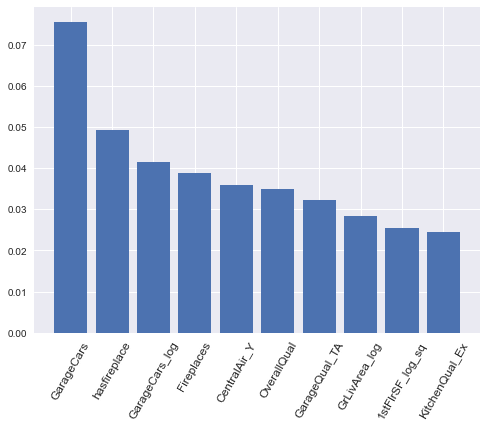

In [74]:
# find the the most important features of the tree
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
index = np.argsort(best_xgb.feature_importances_)[::-1][:10]
features = train.columns[index]

fig = plt.figure(figsize=(8,6))
plt.bar(range(10), best_xgb.feature_importances_[index])
plt.xticks(range(10), features, rotation=60, fontsize=12)
plt.show()

In [75]:
# REALL that we do a log transform for y_train
# make prediction
pred_train_xgb = np.exp(best_xgb.predict(train.values)) - 1
pred_test_xgb = np.exp(best_xgb.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_xgb))))

Train RMSE: 0.0773


In [76]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_xgb
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 987/4657 in the leaderboard, with score=0.12607

## step 2.6 lightGBM

Gradient Boosting Decision Tree (GBDT) is a popular machine learning algorithm, and has quite a few effective implementations such as XGBoost and pGBRT. Although many engineering optimizations have been adopted in these implementations, the efficiency and scalability are still unsatisfactory when the feature dimension is high and data size is large. A major reason is that for each feature,
they need to scan all the data instances to estimate the information gain of all
possible split points, which is very time consuming. 

To tackle this problem, we propose two novel techniques: Gradient-based One-Side Sampling (GOSS) and
Exclusive Feature Bundling (EFB). 

1) With GOSS, we exclude a significant proportion of data instances with small gradients, and only use the rest to estimate the
information gain. We prove that, since the data instances with larger gradients play
a more important role in the computation of information gain, GOSS can obtain
quite accurate estimation of the information gain with a much smaller data size.

2) With EFB, we bundle mutually exclusive features (i.e., they rarely take nonzero
values simultaneously), to reduce the number of features. We prove that finding
the optimal bundling of exclusive features is NP-hard, but a greedy algorithm
can achieve quite good approximation ratio (and thus can effectively reduce the
number of features without hurting the accuracy of split point determination by
much). We call our new GBDT implementation with GOSS and EFB LightGBM.

From https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

In [138]:
import lightgbm as lgb

In [160]:
# these parameter are given in the notebook "Stached Regression"
# They also set learning_rate=0.05. However, I would still like to search for the best learning rate here,
# as a demo for parameter tuning. I think this is also how the original notebook get these parameters.
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              n_estimators=650,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [161]:
# define the parameters you would like to search
learning_rate = [4e-5, 5e-4, 1e-3, 5e-2, 1e-1]
tuned_parameters = [{'learning_rate': learning_rate
                    }]

In [162]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(model_lgb, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', verbose=2)
regressor.fit(train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ................................learning_rate=4e-05; total time=   0.4s
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ................................learning_rate=4e-05; total time=   0.5s
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] baggin

[CV] END ................................learning_rate=0.001; total time=   0.5s
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV] END ................................learning_rate=0.001; total time=   0.4s
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current v

[CV] END ..................................learning_rate=0.1; total time=   0.4s
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


GridSearchCV(cv=5,
             estimator=LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                                     bagging_seed=9, feature_fraction=0.2319,
                                     feature_fraction_seed=9, max_bin=55,
                                     min_data_in_leaf=6,
                                     min_sum_hessian_in_leaf=11,
                                     n_estimators=650, num_leaves=5,
                                     objective='regression'),
             param_grid=[{'learning_rate': [4e-05, 0.0005, 0.001, 0.05, 0.1]}],
             scoring='neg_mean_squared_error', verbose=2)

In [163]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.434362,0.039078,0.010814,0.001101,0.05,{'learning_rate': 0.05},-0.011589,-0.016084,-0.014661,-0.012439,-0.014607,-0.013876,0.001632,1
4,0.418597,0.036792,0.010848,0.000939,0.1,{'learning_rate': 0.1},-0.012620,-0.015988,-0.015876,-0.012942,-0.015203,-0.014526,0.001453,2
2,0.463056,0.038490,0.010750,0.000193,0.001,{'learning_rate': 0.001},-0.071992,-0.090948,-0.088107,-0.072725,-0.076463,-0.080047,0.007939,3
1,0.441670,0.030200,0.009437,0.000902,0.0005,{'learning_rate': 0.0005},-0.101714,-0.126143,-0.119016,-0.101128,-0.105954,-0.110791,0.010025,4
0,0.427254,0.023338,0.009365,0.000867,4e-05,{'learning_rate': 4e-05},-0.144838,-0.175511,-0.163231,-0.142396,-0.148855,-0.154966,0.012556,5


In [164]:
# get the best model
best_lgb = regressor.best_estimator_

<AxesSubplot:>

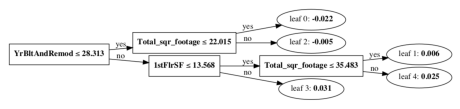

In [165]:
from lightgbm import plot_tree
plot_tree(best_lgb, tree_index=2)

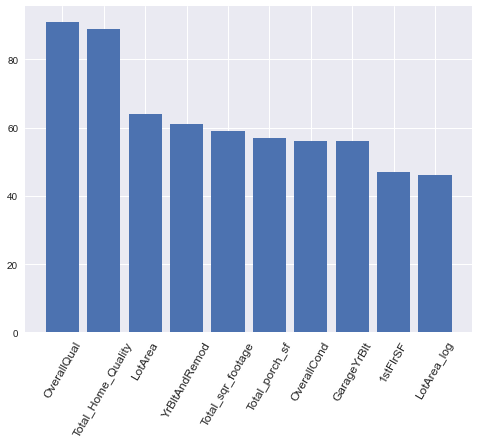

In [166]:
# find the the most important features of the tree
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
index = np.argsort(best_lgb.feature_importances_)[::-1][:10]
features = train.columns[index]

fig = plt.figure(figsize=(8,6))
plt.bar(range(10), best_lgb.feature_importances_[index])
plt.xticks(range(10), features, rotation=60, fontsize=12)
plt.show()

In [167]:
# REALL that we do a log transform for y_train
# make prediction
pred_train_lgb = np.exp(best_lgb.predict(train.values)) - 1
pred_test_lgb = np.exp(best_lgb.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_lgb))))

Train RMSE: 0.0722


In [168]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_lgb
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 1124/4657 in the leaderboard, with score=0.12793

## step 2.7 CatBoosting

CatBoost is developed and maintained by the Russian search engine Yandex. CatBoost distinguishes itself from LightGBM and XGBoost by focusing on optimizing decision trees for categorical variables, or variables whose different values may have no relation with each other (eg. apples and oranges). 

CatBoost is designed for categorical data and is known to have the best performance on it, showing the state-of-the-art performance over XGBoost and LightGBM in eight datasets in its official journal article. As of CatBoost version 0.6, a trained CatBoost tree can predict extraordinarily faster than either XGBoost or LightGBM.

It will set a paramter `one_hot_max_size`,

* if a categorical variable has a number of unique values less than `one_hot_max_size`, than it will be one-hot encoded.
* if a categorical variable has a number of unique values larger than `one_hot_max_size`, than it will use an efficient method of encoding which is similar to mean encoding but reduces overfitting. The process goes like this:
    * Permuting the set of input observations in a random order. Multiple random permutations are generated
    * Converting the label value from a floating point or category to an integer
    * All categorical feature values are transformed to numeric values using the following formula:
    ![title](https://miro.medium.com/max/1000/1*gw_AZFeu-Q0C95W6QWFJ2g.png)
    Where, `CountInClass` is how many times the label value was equal to “1” for objects with the current categorical feature value. `Prior` is the preliminary value for the numerator. It is determined by the starting parameters. `TotalCount` is the total number of objects (up to the current one) that have a categorical feature value matching the current one. 

In [169]:
from catboost import CatBoostRegressor

In [170]:
catboost = CatBoostRegressor(verbose=0,
                             iterations=500,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20,
                             bagging_temperature=0.2,
                            )

In [171]:
# define the parameters you would like to search
learning_rate = [1e-3, 5e-2, 1e-1]
depth = [4,8,10]
l2_leaf_reg = [0, 1e-4, 1e-3, 1e-2, 1e-1]
tuned_parameters = [{'learning_rate': learning_rate,
                     'depth': depth,
                     'l2_leaf_reg': l2_leaf_reg,
                    }]

In [172]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(catboost, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', verbose=2)
regressor.fit(train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END ........depth=4, l2_leaf_reg=0, learning_rate=0.001; total time=   0.9s
[CV] END ........depth=4, l2_leaf_reg=0, learning_rate=0.001; total time=   0.9s
[CV] END ........depth=4, l2_leaf_reg=0, learning_rate=0.001; total time=   1.1s
[CV] END ........depth=4, l2_leaf_reg=0, learning_rate=0.001; total time=   1.1s
[CV] END ........depth=4, l2_leaf_reg=0, learning_rate=0.001; total time=   1.0s
[CV] END .........depth=4, l2_leaf_reg=0, learning_rate=0.05; total time=   1.1s
[CV] END .........depth=4, l2_leaf_reg=0, learning_rate=0.05; total time=   1.1s
[CV] END .........depth=4, l2_leaf_reg=0, learning_rate=0.05; total time=   0.9s
[CV] END .........depth=4, l2_leaf_reg=0, learning_rate=0.05; total time=   1.0s
[CV] END .........depth=4, l2_leaf_reg=0, learning_rate=0.05; total time=   1.0s
[CV] END ..........depth=4, l2_leaf_reg=0, learning_rate=0.1; total time=   1.0s
[CV] END ..........depth=4, l2_leaf_reg=0, lear

[CV] END .....depth=8, l2_leaf_reg=0.0001, learning_rate=0.1; total time=   5.0s
[CV] END .....depth=8, l2_leaf_reg=0.0001, learning_rate=0.1; total time=   5.1s
[CV] END .....depth=8, l2_leaf_reg=0.0001, learning_rate=0.1; total time=   5.1s
[CV] END .....depth=8, l2_leaf_reg=0.0001, learning_rate=0.1; total time=   5.1s
[CV] END ....depth=8, l2_leaf_reg=0.001, learning_rate=0.001; total time=   5.1s
[CV] END ....depth=8, l2_leaf_reg=0.001, learning_rate=0.001; total time=   5.2s
[CV] END ....depth=8, l2_leaf_reg=0.001, learning_rate=0.001; total time=   5.1s
[CV] END ....depth=8, l2_leaf_reg=0.001, learning_rate=0.001; total time=   5.1s
[CV] END ....depth=8, l2_leaf_reg=0.001, learning_rate=0.001; total time=   5.1s
[CV] END .....depth=8, l2_leaf_reg=0.001, learning_rate=0.05; total time=   5.1s
[CV] END .....depth=8, l2_leaf_reg=0.001, learning_rate=0.05; total time=   5.0s
[CV] END .....depth=8, l2_leaf_reg=0.001, learning_rate=0.05; total time=   5.1s
[CV] END .....depth=8, l2_le

[CV] END .....depth=10, l2_leaf_reg=0.01, learning_rate=0.05; total time=  17.0s
[CV] END .....depth=10, l2_leaf_reg=0.01, learning_rate=0.05; total time=  16.8s
[CV] END ......depth=10, l2_leaf_reg=0.01, learning_rate=0.1; total time=  17.0s
[CV] END ......depth=10, l2_leaf_reg=0.01, learning_rate=0.1; total time=  16.9s
[CV] END ......depth=10, l2_leaf_reg=0.01, learning_rate=0.1; total time=  16.8s
[CV] END ......depth=10, l2_leaf_reg=0.01, learning_rate=0.1; total time=  17.0s
[CV] END ......depth=10, l2_leaf_reg=0.01, learning_rate=0.1; total time=  16.9s
[CV] END .....depth=10, l2_leaf_reg=0.1, learning_rate=0.001; total time=  16.8s
[CV] END .....depth=10, l2_leaf_reg=0.1, learning_rate=0.001; total time=  16.9s
[CV] END .....depth=10, l2_leaf_reg=0.1, learning_rate=0.001; total time=  16.9s
[CV] END .....depth=10, l2_leaf_reg=0.1, learning_rate=0.001; total time=  17.0s
[CV] END .....depth=10, l2_leaf_reg=0.1, learning_rate=0.001; total time=  16.6s
[CV] END ......depth=10, l2_

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x1a22d47cc0>,
             param_grid=[{'depth': [4, 8, 10],
                          'l2_leaf_reg': [0, 0.0001, 0.001, 0.01, 0.1],
                          'learning_rate': [0.001, 0.05, 0.1]}],
             scoring='neg_mean_squared_error', verbose=2)

In [173]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_l2_leaf_reg,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.903051,0.036099,0.020272,0.000939,4,0.001,0.05,"{'depth': 4, 'l2_leaf_reg': 0.001, 'learning_r...",-0.010390,-0.013977,-0.013357,-0.011693,-0.012906,-0.012464,0.001279,1
10,0.933390,0.054624,0.021492,0.001351,4,0.01,0.05,"{'depth': 4, 'l2_leaf_reg': 0.01, 'learning_ra...",-0.010701,-0.013959,-0.013818,-0.011293,-0.012762,-0.012507,0.001314,2
1,1.004874,0.066126,0.025551,0.007548,4,0,0.05,"{'depth': 4, 'l2_leaf_reg': 0, 'learning_rate'...",-0.010565,-0.014019,-0.013790,-0.011680,-0.012901,-0.012591,0.001305,3
4,0.963542,0.035509,0.039090,0.034177,4,0.0001,0.05,"{'depth': 4, 'l2_leaf_reg': 0.0001, 'learning_...",-0.010565,-0.013982,-0.013790,-0.011722,-0.012901,-0.012592,0.001291,4
13,0.863817,0.033357,0.020913,0.000992,4,0.1,0.05,"{'depth': 4, 'l2_leaf_reg': 0.1, 'learning_rat...",-0.010810,-0.014005,-0.013762,-0.011938,-0.012932,-0.012690,0.001186,5
14,0.876209,0.029800,0.040013,0.036584,4,0.1,0.1,"{'depth': 4, 'l2_leaf_reg': 0.1, 'learning_rat...",-0.010785,-0.014560,-0.013937,-0.012216,-0.012248,-0.012749,0.001348,6
11,0.847221,0.052244,0.021699,0.001890,4,0.01,0.1,"{'depth': 4, 'l2_leaf_reg': 0.01, 'learning_ra...",-0.010857,-0.015487,-0.013769,-0.012215,-0.012243,-0.012914,0.001583,7
2,0.918949,0.061549,0.020373,0.000866,4,0,0.1,"{'depth': 4, 'l2_leaf_reg': 0, 'learning_rate'...",-0.010578,-0.015099,-0.014670,-0.012228,-0.012255,-0.012966,0.001685,8
5,0.909514,0.047329,0.020258,0.000802,4,0.0001,0.1,"{'depth': 4, 'l2_leaf_reg': 0.0001, 'learning_...",-0.010578,-0.015099,-0.014670,-0.012326,-0.012298,-0.012994,0.001674,9
8,0.933237,0.077211,0.021733,0.001475,4,0.001,0.1,"{'depth': 4, 'l2_leaf_reg': 0.001, 'learning_r...",-0.010776,-0.015267,-0.014819,-0.012505,-0.012349,-0.013143,0.001671,10


In [174]:
# get the best model
best_catboost = regressor.best_estimator_

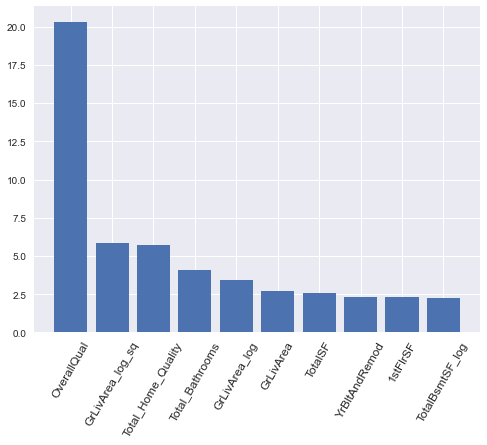

In [175]:
# find the the most important features of the tree
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
index = np.argsort(best_catboost.feature_importances_)[::-1][:10]
features = train.columns[index]

fig = plt.figure(figsize=(8,6))
plt.bar(range(10), best_catboost.feature_importances_[index])
plt.xticks(range(10), features, rotation=60, fontsize=12)
plt.show()

In [176]:
# REALL that we do a log transform for y_train
# make prediction
pred_train_catboost = np.exp(best_catboost.predict(train.values)) - 1
pred_test_catboost = np.exp(best_catboost.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_catboost))))

Train RMSE: 0.0618


In [178]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_catboost
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 1320/4657 in the leaderboard, with score=0.13095

## step 2.8 SVM

In 𝜈-SVR, the parameter 𝜈 is used to determine the proportion of the number of support vectors you desire to keep in your solution with respect to the total number of samples in the dataset. In 𝜈-SVR the parameter 𝜖 is introduced into the optimization problem formulation and it is estimated automatically (optimally) for you.

However, in 𝜖-SVR you have no control on how many data vectors from the dataset become support vectors, it could be a few, it could be many. Nonetheless, you will have total control of how much error you will allow your model to have, and anything beyond the specified 𝜖 will be penalized in proportion to 𝐶, which is the regularization parameter.

Depending of what you want, you choose between the two. If you am really desperate for a small solution (fewer support vectors) you choose 𝜈-SVR and hope to obtain a decent model. But if you really want to control the amount of error in you model and go for the best performance, you choose 𝜖-SVR and hope that the model is not too complex (lots of support vectors).

### step 2.8.1 𝜖-SVR 

In [199]:
from sklearn.svm import SVR

In [200]:
svr_ = SVR(gamma=0.0003)
svr = Pipeline(steps=[('StandardScaler', StandardScaler()), ('svr', svr_)])

In [201]:
# define the parameters you would like to search
epsilon = [0.01, 0.1, 0.2, 0.4, 0.5, 0.8]
C = [0.1, 0.5, 1, 1.5, 2, 10, 20]
tuned_parameters = [{'svr__epsilon': epsilon,
                     'svr__C': C,
                    }]

In [202]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(svr, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', verbose=2)
regressor.fit(train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ......................svr__C=0.1, svr__epsilon=0.01; total time=   0.3s
[CV] END ......................svr__C=0.1, svr__epsilon=0.01; total time=   0.2s
[CV] END ......................svr__C=0.1, svr__epsilon=0.01; total time=   0.2s
[CV] END ......................svr__C=0.1, svr__epsilon=0.01; total time=   0.2s
[CV] END ......................svr__C=0.1, svr__epsilon=0.01; total time=   0.3s
[CV] END .......................svr__C=0.1, svr__epsilon=0.1; total time=   0.1s
[CV] END .......................svr__C=0.1, svr__epsilon=0.1; total time=   0.1s
[CV] END .......................svr__C=0.1, svr__epsilon=0.1; total time=   0.2s
[CV] END .......................svr__C=0.1, svr__epsilon=0.1; total time=   0.1s
[CV] END .......................svr__C=0.1, svr__epsilon=0.1; total time=   0.1s
[CV] END .......................svr__C=0.1, svr__epsilon=0.2; total time=   0.1s
[CV] END .......................svr__C=0.1, svr

[CV] END .......................svr__C=1.5, svr__epsilon=0.2; total time=   0.1s
[CV] END .......................svr__C=1.5, svr__epsilon=0.4; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.4; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.4; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.4; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.4; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.5; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.5; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.5; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.5; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.5; total time=   0.0s
[CV] END .......................svr__C=1.5, svr__epsilon=0.8; total time=   0.0s
[CV] END ...................

[CV] END ........................svr__C=20, svr__epsilon=0.8; total time=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('svr', SVR(gamma=0.0003))]),
             param_grid=[{'svr__C': [0.1, 0.5, 1, 1.5, 2, 10, 20],
                          'svr__epsilon': [0.01, 0.1, 0.2, 0.4, 0.5, 0.8]}],
             scoring='neg_mean_squared_error', verbose=2)

In [203]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,0.184969,0.002131,0.065425,0.008341,2,0.01,"{'svr__C': 2, 'svr__epsilon': 0.01}",-0.011728,-0.015774,-0.015891,-0.011361,-0.015003,-0.013951,0.001992,1
18,0.205895,0.025762,0.075048,0.009895,1.5,0.01,"{'svr__C': 1.5, 'svr__epsilon': 0.01}",-0.011870,-0.015912,-0.015851,-0.011627,-0.015030,-0.014058,0.001913,2
30,0.290172,0.011978,0.063843,0.004859,10,0.01,"{'svr__C': 10, 'svr__epsilon': 0.01}",-0.012681,-0.015738,-0.016723,-0.010696,-0.015111,-0.014190,0.002197,3
12,0.175047,0.005329,0.067045,0.005152,1,0.01,"{'svr__C': 1, 'svr__epsilon': 0.01}",-0.012184,-0.016043,-0.016030,-0.011835,-0.015094,-0.014237,0.001855,4
36,0.331433,0.007787,0.061069,0.001459,20,0.01,"{'svr__C': 20, 'svr__epsilon': 0.01}",-0.013193,-0.015975,-0.017850,-0.011191,-0.015584,-0.014758,0.002319,5
6,0.186715,0.030925,0.076765,0.011055,0.5,0.01,"{'svr__C': 0.5, 'svr__epsilon': 0.01}",-0.013065,-0.016530,-0.016313,-0.012192,-0.015755,-0.014771,0.001789,6
19,0.078245,0.007988,0.024350,0.001869,1.5,0.1,"{'svr__C': 1.5, 'svr__epsilon': 0.1}",-0.012418,-0.016648,-0.017169,-0.012201,-0.017721,-0.015231,0.002411,7
13,0.079763,0.017759,0.024317,0.002056,1,0.1,"{'svr__C': 1, 'svr__epsilon': 0.1}",-0.012469,-0.016754,-0.017321,-0.012549,-0.017550,-0.015329,0.002317,8
25,0.088238,0.009235,0.025116,0.003293,2,0.1,"{'svr__C': 2, 'svr__epsilon': 0.1}",-0.012597,-0.016685,-0.017396,-0.012110,-0.018094,-0.015376,0.002513,9
7,0.080865,0.009618,0.025483,0.001978,0.5,0.1,"{'svr__C': 0.5, 'svr__epsilon': 0.1}",-0.013247,-0.017531,-0.018034,-0.013407,-0.017552,-0.015954,0.002153,10


In [204]:
# get the best model
best_srv = regressor.best_estimator_

In [205]:
# REALL that we do a log transform for y_train
# make prediction
pred_train_srv = np.exp(best_srv.predict(train.values)) - 1
pred_test_srv = np.exp(best_srv.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_srv))))

Train RMSE: 0.0774


In [206]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_srv
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 1474/4657 in the leaderboard, with score=0.13392

### step 2.8.2 𝜈-SVR

In [207]:
from sklearn.svm import NuSVR

In [208]:
nusvr = NuSVR()

In [215]:
# define the parameters you would like to search
nu = [0.1, 0.2, 0.4, 0.5, 0.8, 0.9]
C = [0.1, 0.5, 1, 1.5, 2, 10, 20]
tuned_parameters = [{'nu': nu,
                     'C': C,
                    }]

In [216]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(nusvr, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error', verbose=2)
regressor.fit(train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ......................................C=0.1, nu=0.1; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.1; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.1; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.1; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.1; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.2; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.2; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.2; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.2; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.2; total time=   0.1s
[CV] END ......................................C=0.1, nu=0.4; total time=   0.2s
[CV] END ......................................

[CV] END ......................................C=1.5, nu=0.4; total time=   0.2s
[CV] END ......................................C=1.5, nu=0.4; total time=   0.1s
[CV] END ......................................C=1.5, nu=0.4; total time=   0.2s
[CV] END ......................................C=1.5, nu=0.5; total time=   0.2s
[CV] END ......................................C=1.5, nu=0.5; total time=   0.2s
[CV] END ......................................C=1.5, nu=0.5; total time=   0.2s
[CV] END ......................................C=1.5, nu=0.5; total time=   0.2s
[CV] END ......................................C=1.5, nu=0.5; total time=   0.2s
[CV] END ......................................C=1.5, nu=0.8; total time=   0.3s
[CV] END ......................................C=1.5, nu=0.8; total time=   0.3s
[CV] END ......................................C=1.5, nu=0.8; total time=   0.3s
[CV] END ......................................C=1.5, nu=0.8; total time=   0.2s
[CV] END ...................

[CV] END .......................................C=20, nu=0.8; total time=   0.2s
[CV] END .......................................C=20, nu=0.9; total time=   0.3s
[CV] END .......................................C=20, nu=0.9; total time=   0.2s
[CV] END .......................................C=20, nu=0.9; total time=   0.3s
[CV] END .......................................C=20, nu=0.9; total time=   0.3s
[CV] END .......................................C=20, nu=0.9; total time=   0.3s


GridSearchCV(cv=5, estimator=NuSVR(),
             param_grid=[{'C': [0.1, 0.5, 1, 1.5, 2, 10, 20],
                          'nu': [0.1, 0.2, 0.4, 0.5, 0.8, 0.9]}],
             scoring='neg_mean_squared_error', verbose=2)

In [217]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_nu,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,0.193237,0.021312,0.070025,0.004482,20,0.9,"{'C': 20, 'nu': 0.9}",-0.068581,-0.090324,-0.077097,-0.076566,-0.073940,-0.077302,0.007177,1
40,0.184334,0.014458,0.058799,0.002109,20,0.8,"{'C': 20, 'nu': 0.8}",-0.068418,-0.091059,-0.077618,-0.077391,-0.074133,-0.077724,0.007449,2
39,0.133245,0.007659,0.038680,0.002058,20,0.5,"{'C': 20, 'nu': 0.5}",-0.072395,-0.096068,-0.083002,-0.082080,-0.078340,-0.082377,0.007796,3
38,0.132256,0.015854,0.031710,0.003470,20,0.4,"{'C': 20, 'nu': 0.4}",-0.075225,-0.099091,-0.084997,-0.085140,-0.081443,-0.085179,0.007831,4
35,0.177082,0.016015,0.073144,0.008796,10,0.9,"{'C': 10, 'nu': 0.9}",-0.082760,-0.106670,-0.094057,-0.090128,-0.088115,-0.092346,0.008035,5
34,0.179913,0.007079,0.060218,0.004813,10,0.8,"{'C': 10, 'nu': 0.8}",-0.083620,-0.107209,-0.094562,-0.090318,-0.089297,-0.093001,0.007915,6
33,0.146424,0.017856,0.041973,0.004632,10,0.5,"{'C': 10, 'nu': 0.5}",-0.085665,-0.112117,-0.097659,-0.094101,-0.092006,-0.096310,0.008814,7
37,0.078651,0.008601,0.018620,0.001528,20,0.2,"{'C': 20, 'nu': 0.2}",-0.086400,-0.109996,-0.096072,-0.097719,-0.091904,-0.096418,0.007835,8
32,0.130449,0.014841,0.032498,0.003602,10,0.4,"{'C': 10, 'nu': 0.4}",-0.088206,-0.113782,-0.099829,-0.097225,-0.094508,-0.098710,0.008469,9
36,0.055736,0.005029,0.011268,0.000759,20,0.1,"{'C': 20, 'nu': 0.1}",-0.094273,-0.119382,-0.107650,-0.112662,-0.101304,-0.107054,0.008720,10


In [218]:
# get the best model
best_nusrv = regressor.best_estimator_

In [219]:
# REALL that we do a log transform for y_train
# make prediction
pred_train_nusrv = np.exp(best_nusrv.predict(train.values)) - 1
pred_test_nusrv = np.exp(best_nusrv.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_nusrv))))

Train RMSE: 0.2642


In [220]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_nusrv
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 1952/4657 in the leaderboard, with score=0.14048

Since the performance of the model is not good, we do not put it in the aggregated result.

## Step 2.9 Ridge

In [227]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [228]:
# define your model
ridge_ = Ridge(random_state=0, max_iter=10000)
ridge = Pipeline(steps=[('RobustScaler', RobustScaler()),('ridge', ridge_)])

In [229]:
# define the parameters you would like to search
alphas = np.logspace(-5, 2, 200)
tuned_parameters = [{'ridge__alpha': alphas}]

In [230]:
# search the parameter space with cross-validation
n_folds = 5
regressor = GridSearchCV(ridge, tuned_parameters, cv=n_folds, scoring='neg_mean_squared_error')
regressor.fit(train.values, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('RobustScaler', RobustScaler()),
                                       ('ridge',
                                        Ridge(max_iter=10000,
                                              random_state=0))]),
             param_grid=[{'ridge__alpha': array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-05,
       2.64308149...
       1.55222536e+01, 1.68318035e+01, 1.82518349e+01, 1.97916687e+01,
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02])}],
             scoring='neg

In [231]:
# evaluate the cross-validation process
# since we are using negative_mean_squared_error, the larger the score, the better the model
cv_result = pd.DataFrame(regressor.cv_results_)
cv_result.sort_values('mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
174,0.064818,0.001366,0.000648,0.000015,13.2009,{'ridge__alpha': 13.200884008314167},-0.011785,-0.013720,-0.015697,-0.010962,-0.013063,-0.013046,0.001638,1
173,0.067317,0.000788,0.000713,0.000039,12.1738,{'ridge__alpha': 12.17382727739662},-0.011782,-0.013727,-0.015717,-0.010947,-0.013061,-0.013047,0.001649,2
175,0.065102,0.001107,0.000667,0.000044,14.3146,{'ridge__alpha': 14.314589375234785},-0.011790,-0.013715,-0.015681,-0.010979,-0.013068,-0.013047,0.001627,3
172,0.066387,0.000778,0.000669,0.000014,11.2267,{'ridge__alpha': 11.226677735108137},-0.011779,-0.013735,-0.015740,-0.010933,-0.013061,-0.013050,0.001662,4
176,0.067263,0.000697,0.000694,0.000025,15.5223,{'ridge__alpha': 15.52225357427048},-0.011795,-0.013711,-0.015668,-0.010999,-0.013076,-0.013050,0.001617,5
171,0.064603,0.000900,0.000658,0.000016,10.3532,{'ridge__alpha': 10.353218432956616},-0.011777,-0.013745,-0.015766,-0.010921,-0.013063,-0.013055,0.001674,6
177,0.064182,0.001972,0.000641,0.000010,16.8318,{'ridge__alpha': 16.83180353330955},-0.011801,-0.013710,-0.015658,-0.011020,-0.013086,-0.013055,0.001608,7
170,0.066382,0.000618,0.000675,0.000021,9.54772,{'ridge__alpha': 9.547716114208066},-0.011775,-0.013756,-0.015796,-0.010912,-0.013069,-0.013062,0.001687,8
178,0.065366,0.002522,0.000706,0.000052,18.2518,{'ridge__alpha': 18.251834943190424},-0.011807,-0.013710,-0.015652,-0.011042,-0.013099,-0.013062,0.001599,9
169,0.066890,0.000927,0.000684,0.000020,8.80488,{'ridge__alpha': 8.804883581643464},-0.011774,-0.013769,-0.015829,-0.010904,-0.013077,-0.013071,0.001701,10


best alpha: {'ridge__alpha': 13.200884008314167}


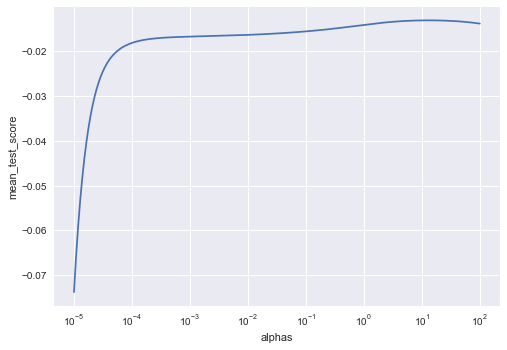

In [232]:
plt.semilogx(alphas, cv_result['mean_test_score'])
plt.xlabel('alphas')
plt.ylabel('mean_test_score')
print('best alpha:', regressor.best_params_)

In [233]:
# get the best model
best_ridge = regressor.best_estimator_

In [234]:
# make prediction
pred_train_ridge = np.exp(best_ridge.predict(train.values)) - 1
pred_test_ridge = np.exp(best_ridge.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_ridge))))

Train RMSE: 0.0949


In [235]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_ridge
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 1227/4657 in the leaderboard, with score=0.12939

## step 2.10 Stacked Regressor

It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.

Stacking addresses the question:

    Given multiple machine learning models that are skillful on a problem, but in different ways, how do you choose which model to use (trust)?

The approach to this question is to use another machine learning model that learns when to use or trust each model in the ensemble.

* Unlike bagging, in stacking, the models are typically different (e.g. not all decision trees) and fit on the same dataset (e.g. instead of samples of the training dataset).
* Unlike boosting, in stacking, a single model is used to learn how to best combine the predictions from the contributing models (e.g. instead of a sequence of models that correct the predictions of prior models).

The architecture of a stacking model involves two or more base models, often referred to as level-0 models, and a meta-model that combines the predictions of the base models, referred to as a level-1 model.

* Level-0 Models (Base-Models): Models fit on the training data and whose predictions are compiled.
* Level-1 Model (Meta-Model): Model that learns how to best combine the predictions of the base models.

The meta-model is trained on the predictions made by base models on out-of-sample data. That is, data not used to train the base models is fed to the base models, predictions are made, and these predictions, along with the expected outputs, provide the input and output pairs of the training dataset used to fit the meta-model.

package: http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

reference: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

In [247]:
from mlxtend.regressor import StackingCVRegressor

In [249]:
stack_gen = StackingCVRegressor(regressors=(best_decision_tree, 
                                            best_gb, 
                                            best_xgb,
                                            best_lgb,
                                            best_catboost,
                                            best_srv,
                                            best_ridge),
                                meta_regressor=best_xgb,
                                use_features_in_secondary=True)

In [250]:
stack_gen.fit(train, y_train)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] 

StackingCVRegressor(meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.4603,
                                                gamma=0.0468, gpu_id=-1,
                                                importance_type='gain',
                                                interaction_constraints='',
                                                learning_rate=0.05,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1.7817,
                                                missing=nan,
                                                monotone_constraints='()',
                                                n_estimators=2200, n_jobs...
      

In [253]:
# make prediction
pred_train_stack = np.exp(stack_gen.predict(train.values)) - 1
pred_test_stack = np.exp(stack_gen.predict(test.values)) - 1

print('Train RMSE: {:.4f}'.format(get_rmse(y_train, np.log(pred_train_stack))))

Train RMSE: 0.0582


In [254]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = pred_test_stack
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 617/4657 in the leaderboard, with score=0.12367

## step 2.11 Scaling the Result

In [309]:
from sklearn.model_selection import cross_val_predict

In [310]:
# it will return the cross-validation prediction of the training set
cross_train_y = cross_val_predict(ridge, train, y_train)

In [311]:
error = cross_train_y - y_train

/Users/zhicongliang/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'negative pct:52.95%')

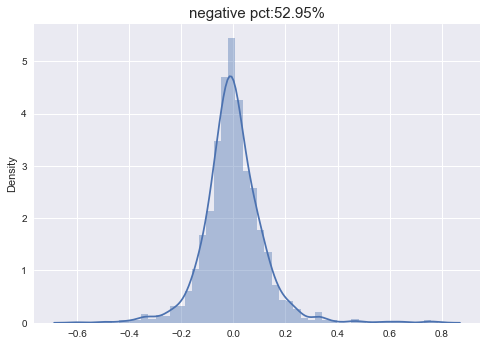

In [312]:
sns.distplot(error)
plt.title('negative pct:{:.2f}%'.format(100* np.mean(error<0)), fontsize=15)

we can see that for 53% of the time we will underestimate the house price. In this case, we want to scale up our prediction a little bit.

## step 2.12 Model Aggregation

In [331]:
agg_pred_test =    pred_test_rf * 0.05 \
                 + pred_test_gb * 0.2 \
                 + pred_test_xgb * 0.1 \
                 + pred_test_lgb * 0.1 \
                 + pred_test_catboost * 0.05\
                 + pred_test_ridge * 0.15 \
                 + pred_test_stack * 0.3 \
                 + pred_test_srv * 0.05

In [334]:
# make submission
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = agg_pred_test * 1.005
submission.to_csv('submission.csv', index=False)

### conclusion:

This model rank 364/4657 in the leaderboard, with score=0.12081.